# CNN Regression Model

In [106]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load

## Sample

<AxesSubplot:title={'center':'Velocity'}>

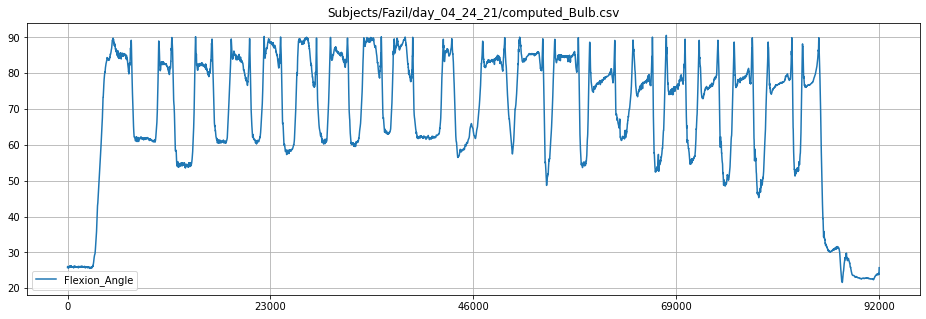

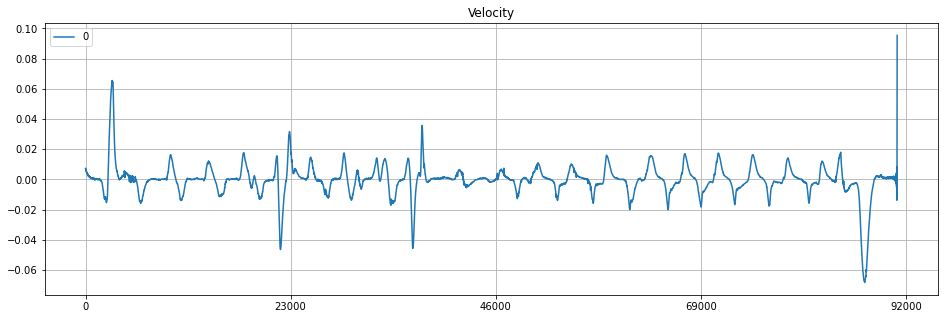

In [107]:
file = 'Subjects/Fazil/day_04_24_21/computed_Bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Flexion_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

arr = np.diff([0]+list(df['Pronation_Angle']))
# arr = arr/df.index
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr[1000:]).plot(figsize=(16,5),title='Velocity',grid=True,xticks=np.linspace(0,len(df),5))

## Prep Data

In [108]:
window = 250

In [109]:
files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21'] #'Fazil/day_04_14_21'
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjec

In [110]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [111]:
files_df = filter_df(files_df)

In [112]:
X, y = multiple_prep_data_velocity(files_df,250,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(151800, 250, 8)

## Time Window Normalize

In [113]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [114]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(121440, 250, 8)
(30360, 250, 8)
(121440, 1)
(30360, 1)


# Neural Network Regression

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [117]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(64,activation='relu'))
model.add(Dense(n_outputs))

model.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 248, 32)           800       
_________________________________________________________________
flatten_4 (Flatten)          (None, 7936)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7937      
Total params: 8,737
Trainable params: 8,737
Non-trainable params: 0
_________________________________________________________________


In [118]:
cnn_history=model.fit(X_train,y_train,epochs = 50,batch_size = 5000,validation_data = (X_test,y_test) )

Epoch 1/50
25/25 [==============================] - 2s 49ms/step - loss: 0.4603 - root_mean_squared_error: 0.6785 - val_loss: 0.1053 - val_root_mean_squared_error: 0.3245
Epoch 2/50
25/25 [==============================] - 1s 41ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1966
Epoch 3/50
25/25 [==============================] - 1s 41ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1559
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 0.0203 - root_mean_squared_error: 0.1423 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1358
Epoch 5/50
25/25 [==============================] - 1s 41ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/50
25/25 [==============================] - 1s 42ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 0.0122 - val_root_m

25/25 [==============================] - 1s 41ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 49/50
25/25 [==============================] - 1s 42ms/step - loss: 9.7110e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 50/50
25/25 [==============================] - 1s 40ms/step - loss: 9.4419e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322


In [68]:
model.save('models/prosup_velocity_model_{}.hdf5'.format(window))

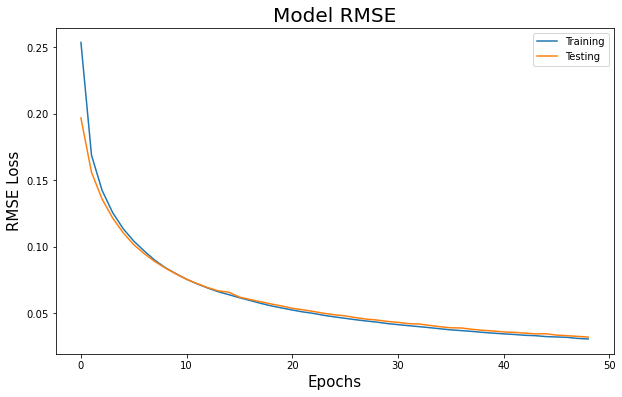

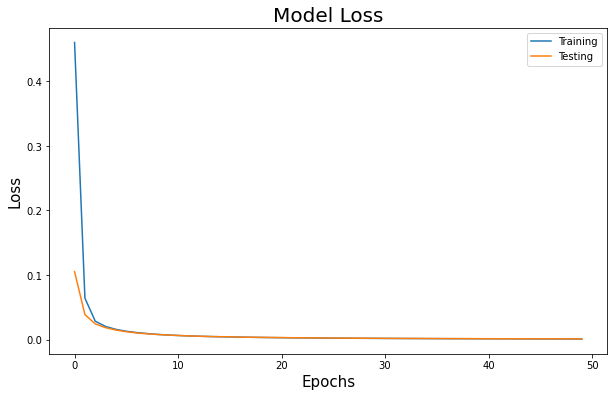

In [119]:
plot_model(cnn_history)

In [69]:
import matplotlib.pyplot as plt
def plot_model(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['root_mean_squared_error'][1:])
    plt.plot(history.history['val_root_mean_squared_error'][1:])
    plt.title('Model RMSE',size=20)
    plt.ylabel('RMSE Loss',size=15)
    plt.xlabel('Epochs', size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',size=20)
    plt.ylabel('Loss',size=15)
    plt.xlabel('Epochs',size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()

## Model Testing

In [120]:
file = 'Subjects/Fazil/day_04_24_21/computed_Bulb.csv'
df = pd.read_csv(file,index_col=0)

In [121]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')

In [122]:
X_mean = np.load('mean_std.npy')[0]
X_std = np.load('mean_std.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

In [123]:
pred = model.predict(X)

In [124]:
from sklearn.metrics import mean_squared_error
print('RMSE Score=',mean_squared_error(y,pred,squared=False))

RMSE Score= 0.1407283056908507


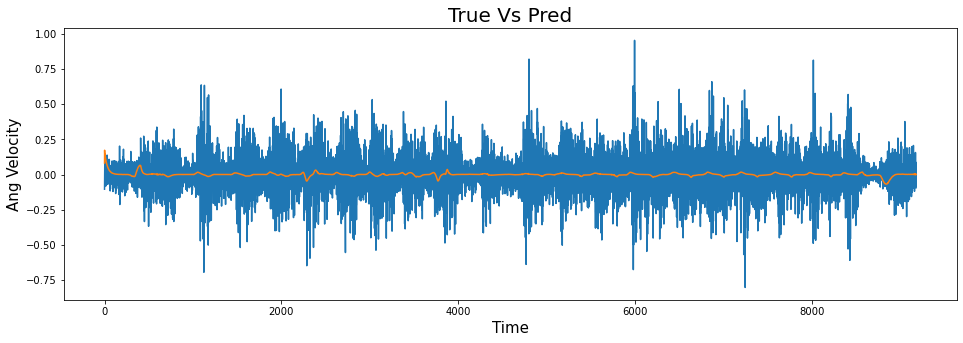

In [125]:
plt.figure(figsize=(16,5))
plt.plot(pred)
plt.plot(y)
plt.title('True Vs Pred',size=20)
plt.ylabel('Ang Velocity',size=15)
plt.xlabel('Time', size=15)
# plt.legend(['True', 'Predicted'], loc='best')
plt.show()